In [2]:
import os

imdb_dir = './dataset'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read().replace('<br />', ' '))
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [3]:
texts[12]

'Inept, boring, and incoherent supernatural "thriller" in which college student Cassie (Melissa Sagemiller) is the constant victim of hallucinations and nightmares after a car accident claims the life of her boyfriend Sean (Casey Affleck).  I can\'t begin to tell you how bad this is...nothing of any importance ever happens nor is there ever any sort of actual entertainment value. I did not like this cast in this particular film - they are all sadly unconvincing (then again, their roles are no good). To promote this as a horror film is a joke. Where are the scares? There\'s no sense or suspense - there are a few good songs but that\'s about it.  How on Earth did this project get the green light? Writer-director Steve Carpenter has no discernible vision or talent that I can sense. Worst of all, the conclusion really makes the whole movie pointless.  The alleged "killer cut" that I watched is 86 minutes of pure tedium.  1/10'

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

training_samples = 200 # We will use only 200 training samples to prove that a powerful pre trained embedding layer is very effective even on little data
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens'%len(word_index))

Found 88582 unique tokens


In [5]:
from math import floor

seq_lengths = np.array([])
for t in texts:
    seq_lengths = np.append(seq_lengths, len(t))

# Use a number somewhere between the minimum length and the mean or median of the texts as the length 
txtlen = floor(seq_lengths.min() + (min(seq_lengths.mean(),np.median(seq_lengths)) - seq_lengths.min()) / 2)
print('Text lengths defined as:', txtlen)

Text lengths defined as: 508


In [6]:
data = pad_sequences(sequences, maxlen=txtlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]


Shape of data tensor: (25000, 508)
Shape of label tensor: (25000,)


In [7]:
print(x_train.shape,y_train.shape,x_val.shape,y_val.shape)

(200, 508) (200,) (10000, 508) (10000,)


In [8]:
# Decode a random text
for w in x_train[22]:
    if w != 0:
        print(list(word_index.keys())[list(word_index.values()).index(w)], end=' ')

eric the lady and the duke could have used a better translation for the title the english woman and the duke perhaps would have been more accurate while it's obvious this film is not for everyone judging by the comments to this forum it is worth watching because in spite of the intricate pattern of the story mr rohmer has created a movie that could be seen as an art exhibit in a museum the mixed technology used in the movie ultimately works well the strange story of grace elliott a noble lady who had been the mistress of the king of england and of the french holds our attention the setting is paris during the days that followed the french revolution the country was in turmoil and the power was in the hands of the people who couldn't care less for the the images show the running around with heads of famous people right after their trip to the grace relation with the had ended but she remains a true friend to the great man that is in danger himself of losing his own head grace moves thro

In [9]:
# Load the GloVe word embeddings
glove_dir = '/Users/daniel/Documents/IC/chollet-experiments/chapter-6-rnns/glove.6B'
embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [10]:
# Map the text words to the word embeddings
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [11]:
# Create model
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=txtlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 508, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 50800)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1625632   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 2,625,665
Trainable params: 2,625,665
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Load the GloVe weights into the embedding layer and freeze its parameters
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [13]:
# Train model
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['acc'])

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 2s 268ms/step - loss: 2.6387 - acc: 0.5500 - val_loss: 0.9037 - val_acc: 0.5005
Epoch 2/10
7/7 [==============================] - 2s 248ms/step - loss: 0.5820 - acc: 0.7200 - val_loss: 0.7521 - val_acc: 0.5245
Epoch 3/10
7/7 [==============================] - 2s 231ms/step - loss: 0.2616 - acc: 0.9250 - val_loss: 1.3614 - val_acc: 0.4999
Epoch 4/10
7/7 [==============================] - 2s 272ms/step - loss: 0.2511 - acc: 0.8950 - val_loss: 1.1769 - val_acc: 0.5011
Epoch 5/10
7/7 [==============================] - 2s 327ms/step - loss: 0.1620 - acc: 0.9500 - val_loss: 0.7550 - val_acc: 0.5398
Epoch 6/10
7/7 [==============================] - 2s 336ms/step - loss: 0.0587 - acc: 1.0000 - val_loss: 0.9029 - val_acc: 0.5288
Epoch 7/10
7/7 [==============================] - 2s 344ms/step - loss: 0.0423 - acc: 1.0000 - val_loss: 0.9008 - val_acc: 0.5214
Epoch 8/10
7/7 [==============================] - 2s 334ms/step - loss: 0.0231 - acc: 1.00

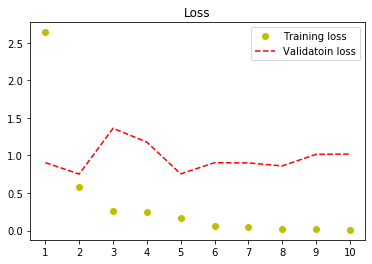

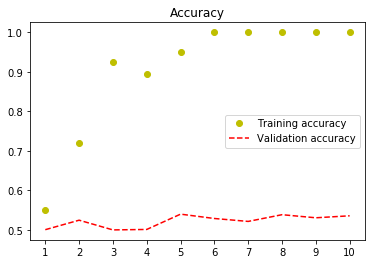

In [14]:
from util import plot_history

plot_history(history)

Epoch 1/10
625/625 [==============================] - 20s 33ms/step - loss: 0.6564 - acc: 0.6487 - val_loss: 0.6159 - val_acc: 0.6544
Epoch 2/10
625/625 [==============================] - 20s 32ms/step - loss: 0.4734 - acc: 0.7748 - val_loss: 0.5406 - val_acc: 0.7358
Epoch 3/10
625/625 [==============================] - 20s 32ms/step - loss: 0.3565 - acc: 0.8411 - val_loss: 0.5734 - val_acc: 0.7352
Epoch 4/10
625/625 [==============================] - 21s 33ms/step - loss: 0.2713 - acc: 0.8827 - val_loss: 0.7054 - val_acc: 0.7218
Epoch 5/10
625/625 [==============================] - 17s 27ms/step - loss: 0.1951 - acc: 0.9188 - val_loss: 0.7652 - val_acc: 0.7326
Epoch 6/10
625/625 [==============================] - 16s 25ms/step - loss: 0.1366 - acc: 0.9457 - val_loss: 1.7548 - val_acc: 0.6394
Epoch 7/10
625/625 [==============================] - 20s 31ms/step - loss: 0.0985 - acc: 0.9611 - val_loss: 1.0045 - val_acc: 0.7264
Epoch 8/10
625/625 [==============================] - 19s 31ms

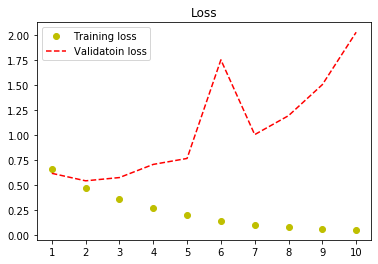

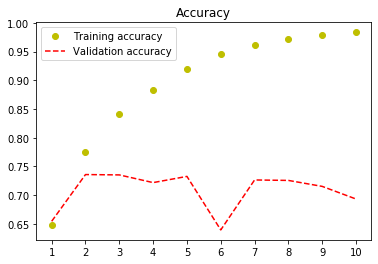

In [15]:
# Try with all the data available for training
train_pct = 0.8
x_train = data[:round(len(data) * train_pct)]
y_train = labels[:round(len(data) * train_pct)]
x_val = data[round(len(data) * train_pct):]
y_val = labels[round(len(data) * train_pct):]

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

plot_history(history)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 508, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1625632   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,625,665
Trainable params: 2,625,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 21s 34ms/step - loss: 0.4969 - acc: 0.7191 - val_loss: 0.3014 - val_acc: 0.8786
Epoch 2/10
625/625 [==============================] - 25s 41ms/step - loss: 0.1599 - acc: 0.9400 - val_loss:

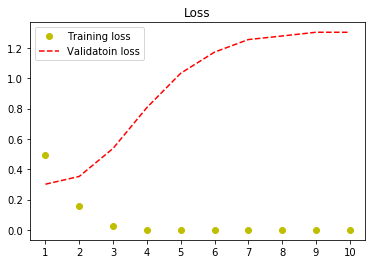

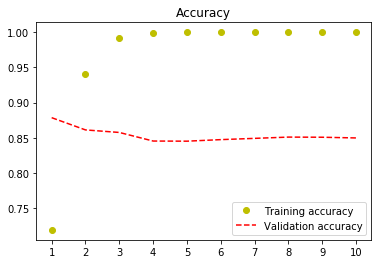

In [16]:
# Compare with self trained embedding
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=txtlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

plot_history(history)

Epoch 1/10
625/625 [==============================] - 26s 42ms/step - loss: 0.5975 - acc: 0.6895 - val_loss: 0.4112 - val_acc: 0.8224
Epoch 2/10
625/625 [==============================] - 22s 35ms/step - loss: 0.3117 - acc: 0.8676 - val_loss: 0.5091 - val_acc: 0.7812
Epoch 3/10
625/625 [==============================] - 21s 33ms/step - loss: 0.1666 - acc: 0.9371 - val_loss: 0.4122 - val_acc: 0.8454
Epoch 4/10
625/625 [==============================] - 22s 35ms/step - loss: 0.0769 - acc: 0.9735 - val_loss: 0.4426 - val_acc: 0.8514
Epoch 5/10
625/625 [==============================] - 25s 41ms/step - loss: 0.0313 - acc: 0.9904 - val_loss: 0.6175 - val_acc: 0.8416
Epoch 6/10
625/625 [==============================] - 21s 33ms/step - loss: 0.0122 - acc: 0.9964 - val_loss: 0.7059 - val_acc: 0.8504
Epoch 7/10
625/625 [==============================] - 24s 39ms/step - loss: 0.0053 - acc: 0.9983 - val_loss: 0.8316 - val_acc: 0.8418
Epoch 8/10
625/625 [==============================] - 26s 42ms

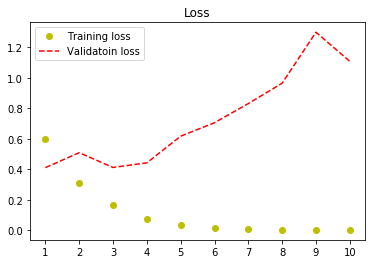

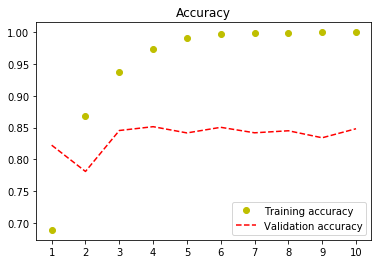

In [20]:
# Compare with using pre trained embedding, but trainable
model.reset_states()
model.layers[0].set_weights([embedding_matrix])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
plot_history(history)


In [21]:
# Test initial model
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=txtlen)
y_test = np.asarray(labels)

In [22]:

model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 4s 5ms/step - loss: 1.0189 - acc: 0.5372


[1.0188623666763306, 0.5371999740600586]